## Import Librarys

In [1]:
import numpy as np,  pandas as pd,  matplotlib.pyplot as plt, seaborn as sns
import datetime as dt 
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

import shap
import optuna

import joblib as jb
from tabulate import tabulate
pd.options.display.float_format = '{:.2f}'.format

import warnings 
warnings.filterwarnings('ignore')

c:\Users\user\Documents\python\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
stocks = {}
stocks['HPG'] = pd.read_csv(r'C:\Users\user\Documents\python\Samsung\Data\HPG_price.csv', parse_dates=['time'], index_col='time')
stocks['HSG'] = pd.read_csv(r'C:\Users\user\Documents\python\Samsung\Data\HSG_price.csv', parse_dates=['time'], index_col='time')

In [4]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.info())
    print("="*30)

Stock of: HPG
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2628 entries, 2015-01-05 to 2025-07-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2628 non-null   float64
 1   high    2628 non-null   float64
 2   low     2628 non-null   float64
 3   close   2628 non-null   float64
 4   volume  2628 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 123.2 KB
None
Stock of: HSG
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2628 entries, 2015-01-05 to 2025-07-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2628 non-null   float64
 1   high    2628 non-null   float64
 2   low     2628 non-null   float64
 3   close   2628 non-null   float64
 4   volume  2628 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 123.2 KB
None


In [5]:
def ffill_value(stocks):
    for company, data in stocks.items():
        data.loc[data['volume'] == 0, :] = np.nan
        data = data.ffill()
        stocks[company] = data
    return stocks

In [6]:
ffill_value(stocks)

{'HPG':             open  high   low  close      volume
 time                                           
 2015-01-05  3.44  3.51  3.41   3.44   207020.00
 2015-01-06  3.38  3.47  3.38   3.47   260380.00
 2015-01-07  3.47  3.51  3.44   3.44   232770.00
 2015-01-08  3.44  3.47  3.41   3.44   107380.00
 2015-01-09  3.44  3.51  3.41   3.51   409230.00
 ...          ...   ...   ...    ...         ...
 2025-07-08 23.65 24.80 23.55  24.70 77535019.00
 2025-07-09 24.80 25.10 24.60  24.75 43462900.00
 2025-07-10 24.85 25.20 24.55  25.15 85282300.00
 2025-07-11 25.25 26.25 25.05  26.00 65285300.00
 2025-07-14 26.20 26.45 25.55  25.75 49438500.00
 
 [2628 rows x 5 columns],
 'HSG':             open  high   low  close      volume
 time                                           
 2015-01-05  6.69  6.69  6.56   6.56    89620.00
 2015-01-06  6.56  6.56  6.47   6.56    43850.00
 2015-01-07  6.56  6.77  6.52   6.62   332520.00
 2015-01-08  6.70  6.70  6.54   6.63   103620.00
 2015-01-09  6.63  6.65  6.

## EDA

In [72]:
for key, value in stocks.items():
    print('Stock of:', key)
    print(value.describe())
    print("="*30)

Stock of: HPG
         open    high     low   close      volume
count 2628.00 2628.00 2628.00 2628.00     2628.00
mean    13.25   13.42   13.08   13.24 13488812.32
std      8.20    8.29    8.09    8.18 13023249.26
min      2.40    2.48    2.38    2.47    77750.00
25%      6.26    6.37    6.22    6.29  3442032.50
50%     10.52   10.65   10.39   10.52  9469150.00
75%     21.06   21.25   20.81   21.02 20277390.75
max     33.25   33.48   32.97   33.25 99679984.00
Stock of: HSG
         open    high     low   close      volume
count 2628.00 2628.00 2628.00 2628.00     2628.00
mean    13.56   13.79   13.32   13.54  6629603.26
std      7.57    7.70    7.44    7.55  5962122.61
min      2.98    3.18    2.89    3.02    19220.00
25%      6.36    6.45    6.26    6.33  1871022.50
50%     13.14   13.43   12.84   13.11  4869060.00
75%     17.76   18.17   17.50   17.76 10093096.50
max     38.37   39.29   37.99   38.18 43671883.00


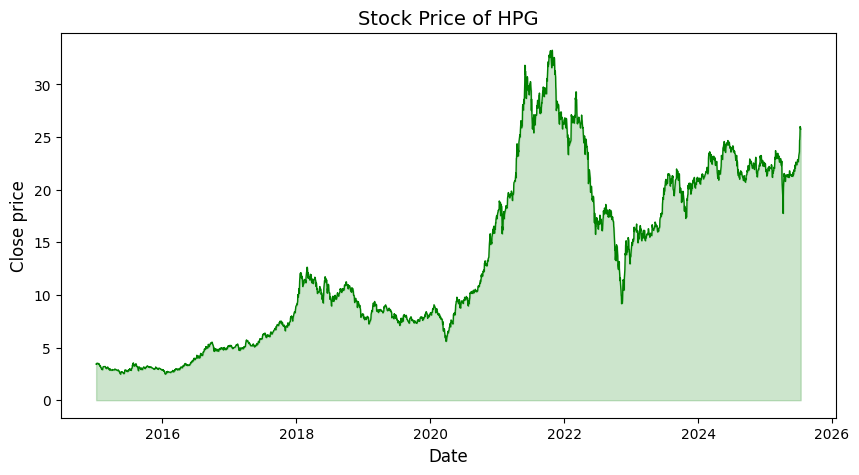

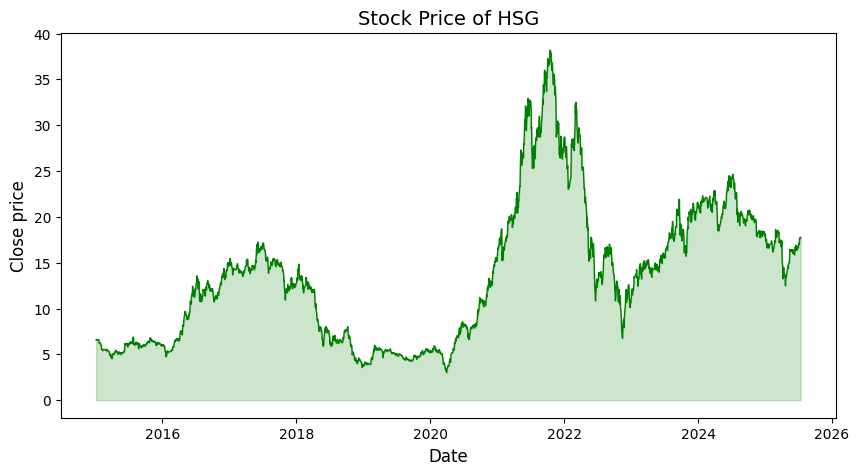

In [73]:
for company, data in stocks.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['close'], color='green', linewidth=1)

    ax.fill_between(data.index, data['close'], alpha=0.2, color='green')

    ax.set_title(f"Stock Price of {company}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Close price", fontsize=12)

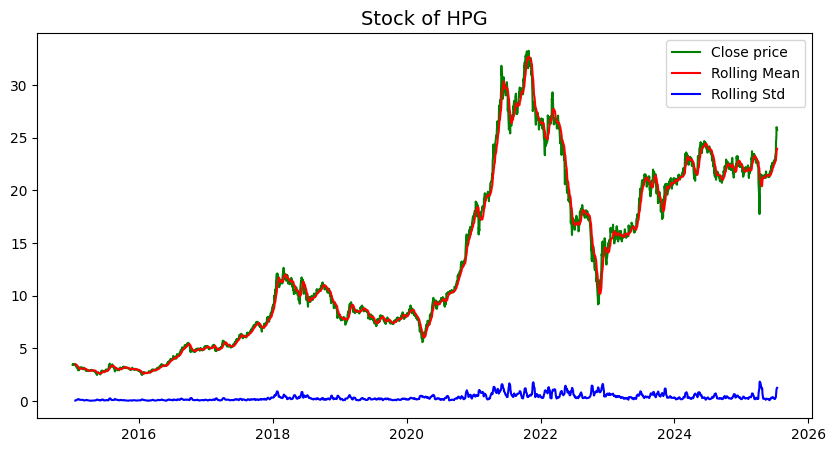

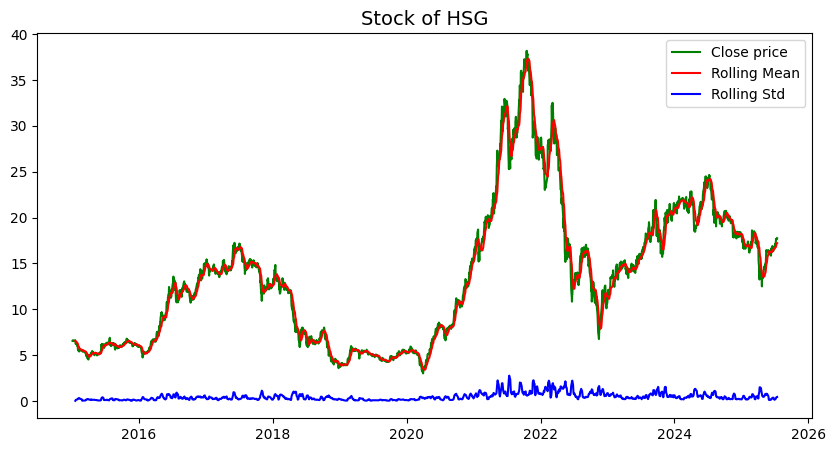

In [74]:
for key, value in stocks.items():
    rolling_mean = value['close'].rolling(window=12).mean()
    rolling_std = value['close'].rolling(window=12).std()
    price = value['close']
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(price, color='green', label='Close price')
    ax.plot(rolling_mean, color='red', label='Rolling Mean')
    ax.plot(rolling_std, color='blue', label='Rolling Std')
    
    ax.set_title(f'Stock of {key}', fontsize=14)
    ax.legend()

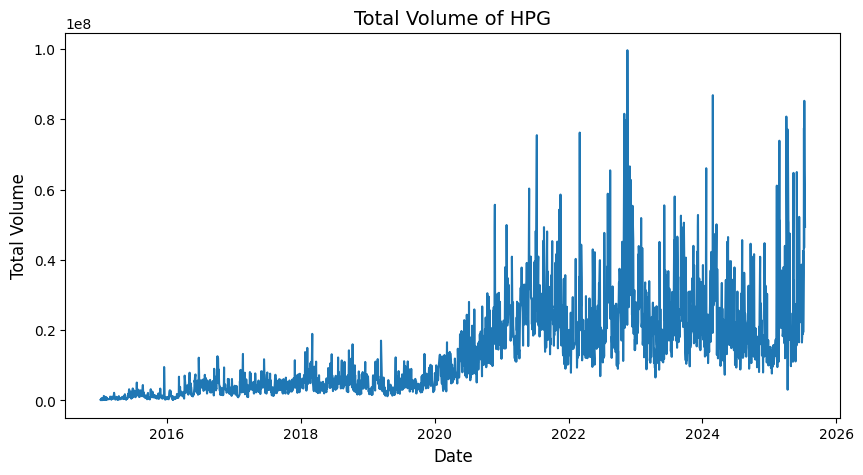

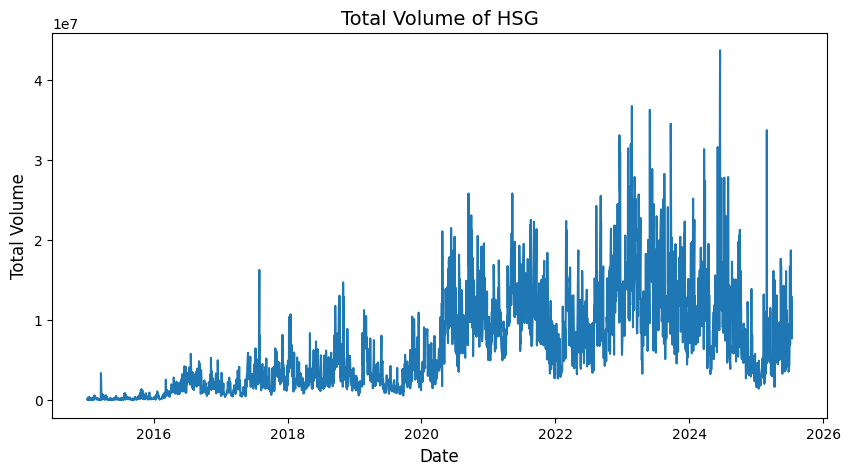

In [75]:
for company, data in stocks.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data['volume'])

    ax.set_title(f"Total Volume of {company}", fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Total Volume", fontsize=12)

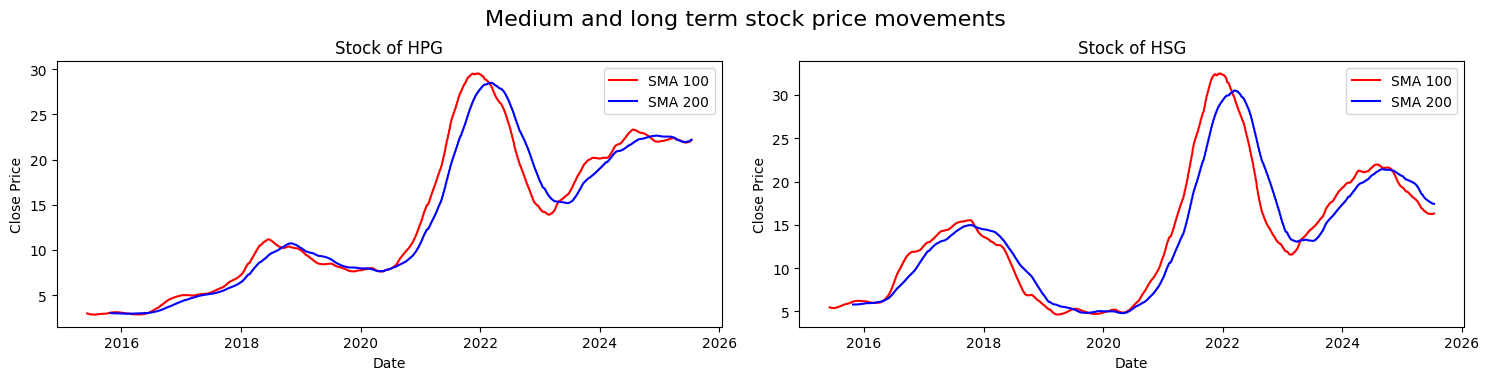

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
for idx, (key, value) in enumerate(stocks.items()):
    ax = axes[idx]
    SMA_100 = value['close'].rolling(window=100).mean()
    SMA_200 = value['close'].rolling(window=200).mean()
    ax.plot(SMA_100, color='red', label='SMA 100')
    ax.plot(SMA_200, color='blue', label='SMA 200')
    ax.set_title(f'Stock of {key}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend()
for ax in axes[len(stocks):]:
    ax.remove()
fig.suptitle("Medium and long term stock price movements", fontsize=16)    

plt.tight_layout()
plt.show()

Cổ phiếu HPG


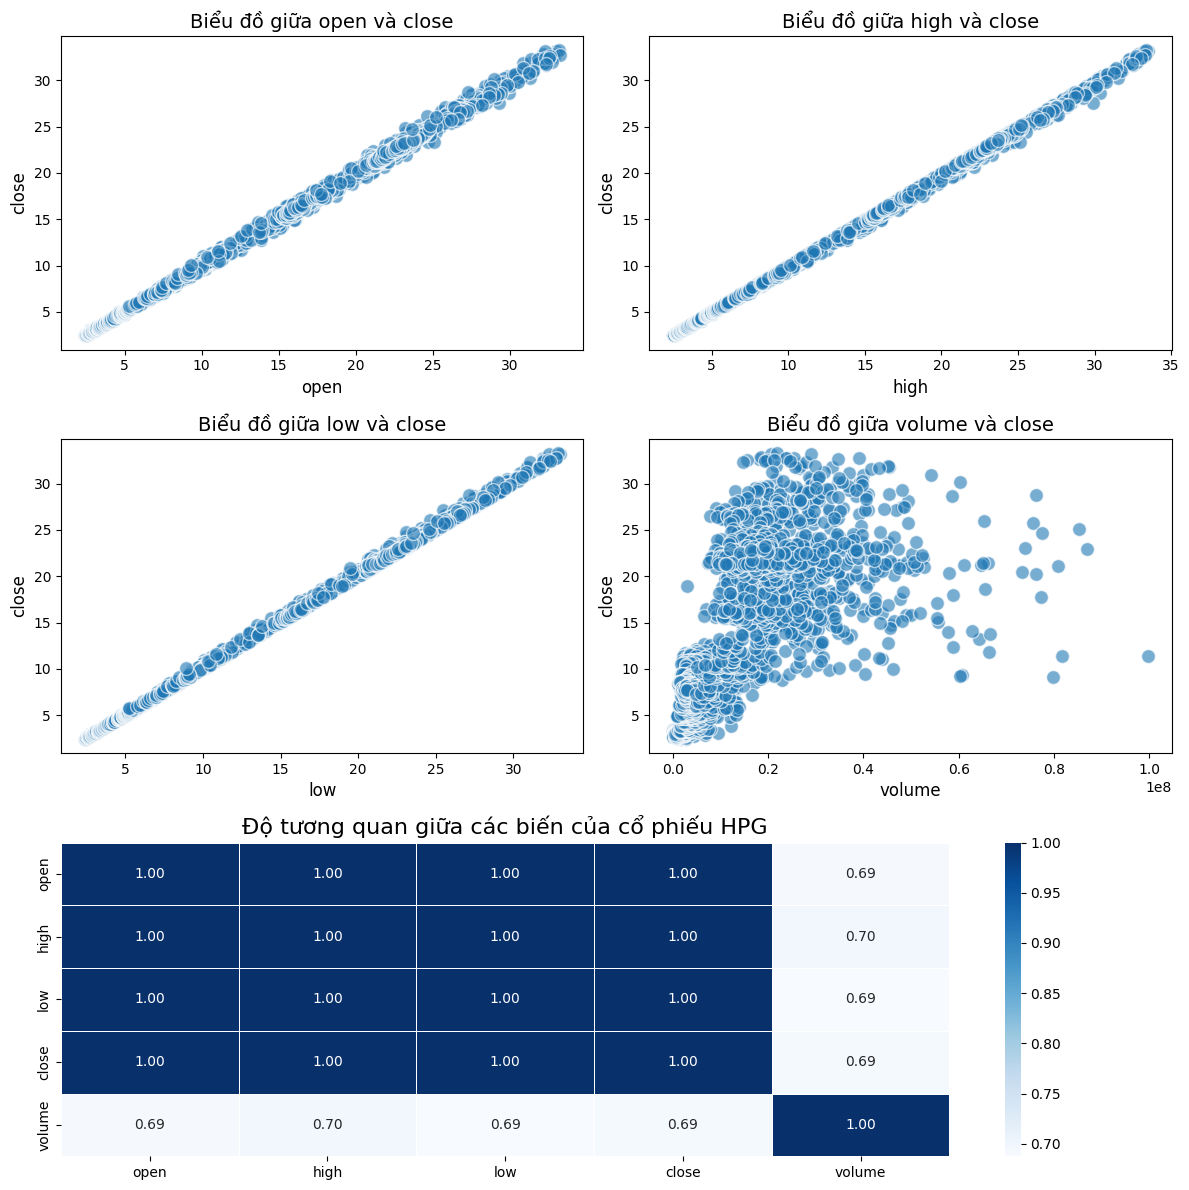

Cổ phiếu HSG


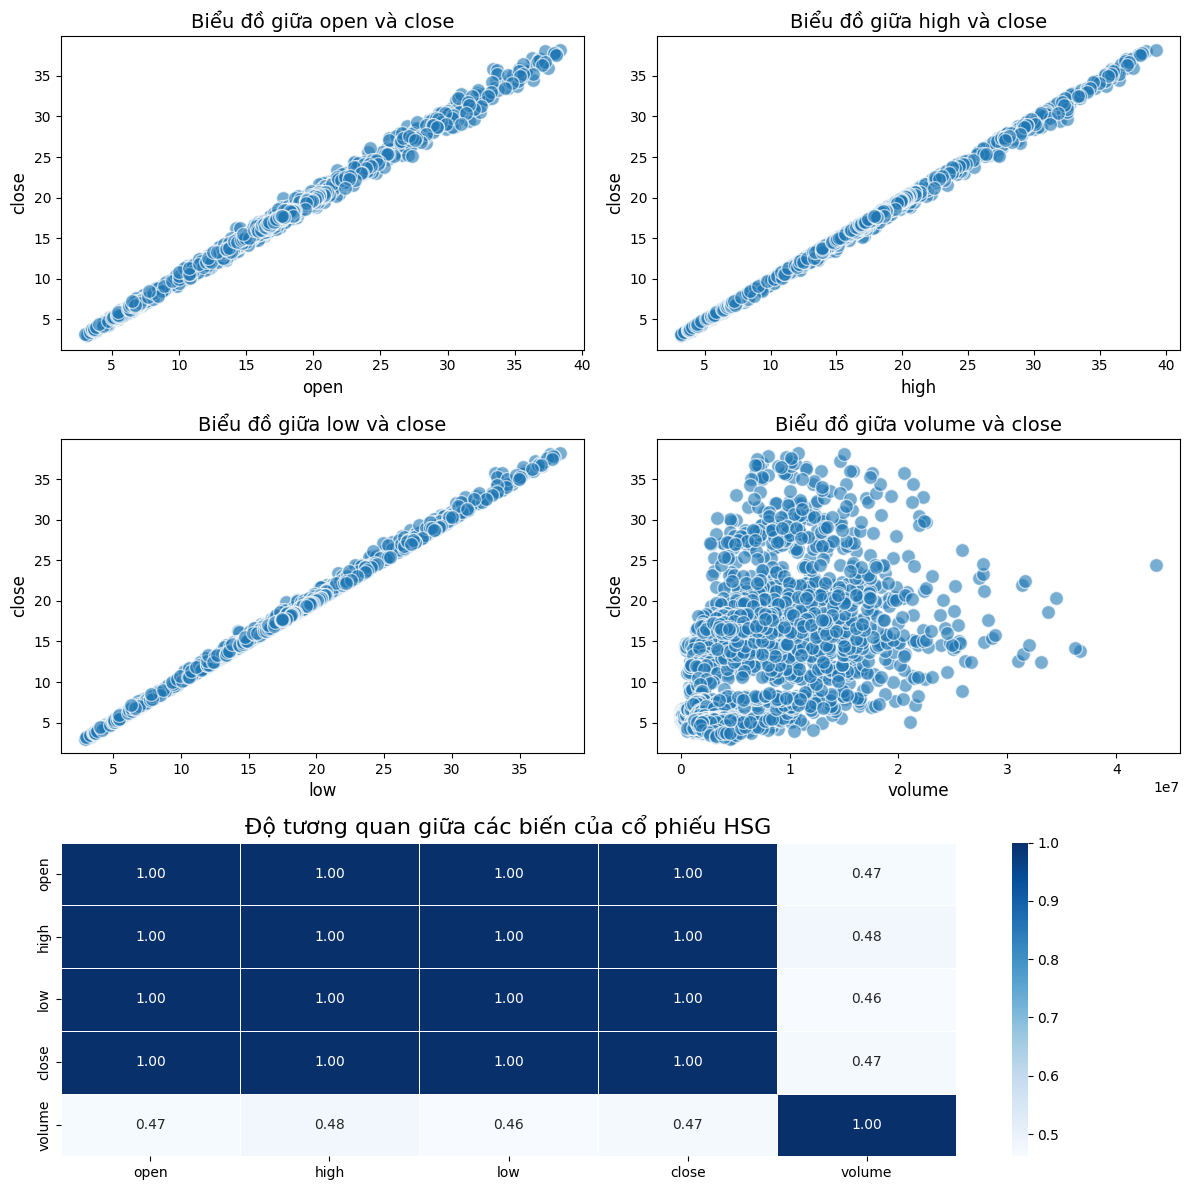

In [77]:
def relationship_plot(key, value):
    print(f"Cổ phiếu {key}")
    X = ['open', 'high', 'low', 'volume']
    y = 'close'
    
    n_scatter = len(X)
    n_scatter_rows = math.ceil(n_scatter / 2)
    total_rows = n_scatter_rows + 1
    
    fig, axes = plt.subplots(total_rows, 2, figsize=(12, 4*total_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    
    for i, col in enumerate(X):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].scatter(value[col], value[y], alpha=0.6, edgecolors='w', s=100)
        axes[row, col_idx].set_title(f"Biểu đồ giữa {col} và {y}", fontsize=14)
        axes[row, col_idx].set_xlabel(col, fontsize=12)
        axes[row, col_idx].set_ylabel(y, fontsize=12)
    
    if n_scatter % 2 != 0:
        axes[n_scatter_rows - 1, 1].axis('off')
    
    for j in range(2):
        fig.delaxes(axes[-1, j])
    ax_heat = fig.add_subplot(total_rows, 1, total_rows)
    value_corr = value.select_dtypes(include=[float, int]).corr()
    sns.heatmap(value_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=ax_heat)
    ax_heat.set_title(f"Độ tương quan giữa các biến của cổ phiếu {key}", fontsize=16)
    
    plt.tight_layout()
    plt.show()

for company, data in stocks.items():
    relationship_plot(company, data)

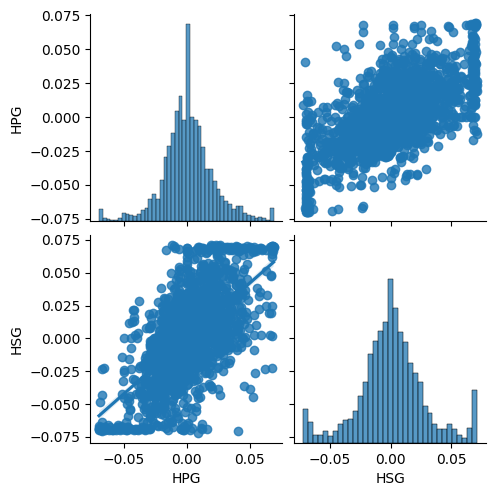

In [78]:
stocks_copy = stocks.copy()
for company, data in stocks_copy.items():
    data['Daily_Return'] = data['close'].pct_change()
    
combined_daily_return = pd.DataFrame({
    'HPG': stocks_copy['HPG']['Daily_Return'],
    'HSG': stocks_copy['HSG']['Daily_Return']
})

combined_closing_price = pd.DataFrame({
    'HPG': stocks_copy['HPG']['close'],
    'HSG': stocks_copy['HSG']['close']
})

combined_daily_return = combined_daily_return.dropna()
sns.pairplot(combined_daily_return, kind='reg')


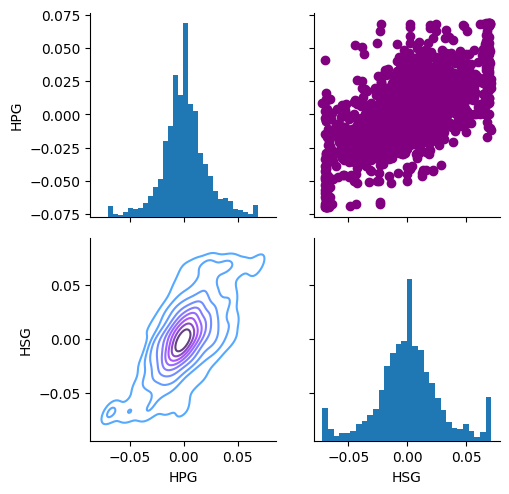

In [79]:
return_fig = sns.PairGrid(combined_daily_return.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30);

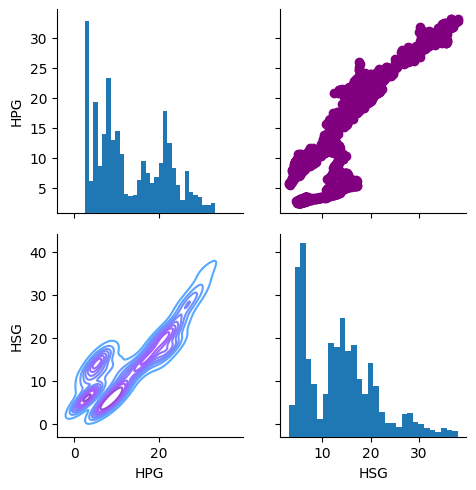

In [80]:
return_fig = sns.PairGrid(combined_closing_price.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30);

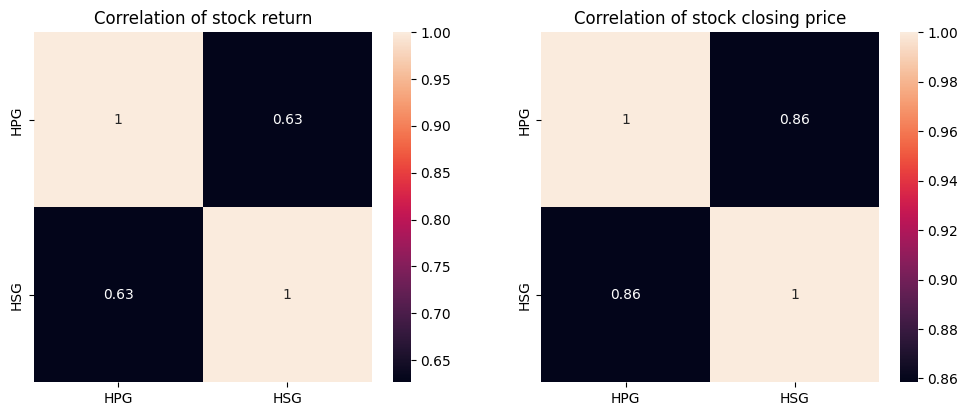

In [82]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(combined_daily_return.corr(), annot=True)
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(combined_closing_price.corr(), annot=True)
plt.title('Correlation of stock closing price');

Giá đóng cửa của cả 2 công ty có mối tương quan khá cao với nhau. Bên cạnh đó, lợi nhuận cổ phiếu hằng ngày của 2 công ty có mối tương quan trung bình. Do đây là 2 công ty cùng ngành nên sẽ chịu tác động chung từ thị trường.

## Data Preprocessing


In [7]:
def create_features(data):
    """
    Create technical indicators and statistical features
    """
    # Price movements
    data['Price_Range'] = data['high'] - data['low']
    data['Daily_Return'] = data['close'].pct_change()
    
    # Moving averages
    data['MA_5'] = data['close'].rolling(window=5).mean()
    data['MA_10'] = data['close'].rolling(window=10).mean()
    data['MA_20'] = data['close'].rolling(window=20).mean()
    
    # Momentum indicators
    data['Momentum_5'] = data['close'].diff(5)
    data['Momentum_10'] = data['close'].diff(10)
    
    # Volatility
    data['Volatility_5'] = data['close'].rolling(window=5).std()
    data['Volatility_10'] = data['close'].rolling(window=10).std()
    
    # Relative Strength Index (RSI)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop NA values from feature creation
    data = data.dropna()
    
    return data

# for company, data in stocks.items():
#     print(f"Creating features for {company}")
#     stocks[company] = create_features(data)

#     print(f"Dataset after feature engineering: {stocks[company].shape}")


In [8]:
def normalize_data(data):
    """
    Normalize features using MinMaxScaler
    """
    features = ['open', 'high', 'low', 'close', 'volume', 'Price_Range', 'Daily_Return',
                'MA_5', 'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10', 'Volatility_5',
                'Volatility_10', 'RSI']
    
    # Initialize scalers
    # close_scaler = MinMaxScaler(feature_range=(0, 1))
    # feature_scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale close price separately (target)
    # data['Close_scaled'] = close_scaler.fit_transform(data[['close']])
    
    # Scale other features
    # data[features] = feature_scaler.fit_transform(data[features])
    
    return scaler

## Data Preparation

In [16]:
def create_sequences(data, time_steps, target='close'):
    X, y = [], []
    features = ['open', 'high', 'low', 'close', 'volume', 'Price_Range', 'Daily_Return',
                'MA_5', 'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10', 'Volatility_5',
                'Volatility_10', 'RSI']
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i : i + time_steps][features].values)
        y.append(data.iloc[i + time_steps][target]) 
    return np.array(X), np.array(y)

# Data augmentation with jittering
def jitter(X, noise_factor=0.01):
    """
    Add small random noise to sequences for data augmentation
    """
    noise = np.random.normal(0, noise_factor, X.shape)
    return X + noise


In [12]:
# Train-test split with time series cross-validation
def train_test_split_time_series(X, y, test_size=0.2):
    """
    Custom time series split that maintains temporal order
    """
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return X_train, X_test, y_train, y_test

## Model building

In [18]:

def training_LSTM(data, time_steps=180, test_size=0.2):
    # 1) Create features
    data = create_features(data)

    # 2) Tạo sequence
    X, y = create_sequences(data, time_steps)
    y = y.reshape(-1, 1)
    
    # 3) Train/test split
    X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, test_size)

    #4 Scale
    n_timesteps, n_feats = X_train.shape[1], X_train.shape[2]
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_train_flat = X_train.reshape(-1, n_feats)
    scaler_X.fit(X_train_flat)
    
    X_train_scaled = scaler_X.transform(X_train_flat).reshape(-1, n_timesteps, n_feats)
    X_test_flat  = X_test.reshape(-1, n_feats)
    X_test_scaled = scaler_X.transform(X_test_flat).reshape(-1, n_timesteps, n_feats)
    
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit(y_train)
    y_train_scaled = scaler_y.transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)
    
    #5 Data augmentation with jittering
    X_train_augmented = jitter(X_train_scaled)
    y_train_augmented = y_train_scaled.copy()
    
    X_train_full = np.concatenate([X_train, X_train_augmented])
    y_train_full = np.concatenate([y_train_scaled, y_train_augmented])
    print(f"Train shape after augment: X={X_train_full.shape}, y={y_train_full.shape}")
    print(f"Test shape:               X={X_test.shape},     y={y_test_scaled.shape}")

    
    # 6) Build model LSTM
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_feats)),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 7) Early stopping & fit
    early_stop = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
    history = model.fit(
        X_train_full, y_train_full,
        epochs=100, batch_size=32,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[early_stop],
        verbose=1
    )

    # 8) Evaluate train/test data
    train_loss = model.evaluate(X_train_full, y_train_full, verbose=0)
    test_loss  = model.evaluate(X_test_scaled,  y_test_scaled,  verbose=0)
    print(f"Training loss: {train_loss:.4f}, Testing loss: {test_loss:.4f}")

    # 9) predict và unscale
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
    y_true = scaler_y.inverse_transform(y_test_scaled).ravel()

    # 10) Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)

    # 11) Date by y_test
    test_dates = data.index[-len(y_true):]

    return {
        'model': model,
        'MAE': round(mae, 6),
        'MSE': round(mse, 6),
        'R2': round(r2, 4),
        'Actual': y_true,
        'Predict': y_pred,
        'Test dates': test_dates,
        'History': history
    }



In [22]:
# XGBoost Model
def training_XGB(data, time_steps=180, test_size=0.2,
                 n_estimators=100, max_depth=5, learning_rate=0.1):
    # 1) Feature engineering
    data_feat = create_features(data)

    # 2) Create sequences (raw)
    X_seq, y = create_sequences(data_feat, time_steps)
    y = y.reshape(-1, 1)

    # 3) Train/test split on raw sequences
    # Flatten for split consistency
    n_samples, ts, n_feats = X_seq.shape
    X_flat = X_seq.reshape(n_samples, ts * n_feats)
    X_train_flat, X_test_flat, y_train, y_test = train_test_split_time_series(
        X_flat, y, test_size
    )
    print(f"Training set: X={X_train_flat.shape}, y={y_train.shape}")
    print(f"Testing set:  X={X_test_flat.shape}, y={y_test.shape}")

    # 4) Scale features *only on train*
    scaler_X = MinMaxScaler(feature_range=(0,1))
    scaler_X.fit(X_train_flat)
    X_train_scaled = scaler_X.transform(X_train_flat)
    X_test_scaled  = scaler_X.transform(X_test_flat)

    # 5) Scale target *only on train*
    scaler_y = MinMaxScaler(feature_range=(0,1))
    scaler_y.fit(y_train)
    y_train_scaled = scaler_y.transform(y_train)
    y_test_scaled  = scaler_y.transform(y_test)

    # 6) Data augmentation on train
    X_train_aug = jitter(X_train_scaled.reshape(-1, ts, n_feats)).reshape(-1, ts * n_feats)
    y_train_aug = y_train_scaled.copy()

    X_train_full = np.concatenate([X_train_scaled, X_train_aug], axis=0)
    y_train_full = np.concatenate([y_train_scaled, y_train_aug], axis=0).ravel()
    print(f"Augmented train: X={X_train_full.shape}, y={y_train_full.shape}")

    # 7) Build & fit XGBoost
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )
    model.fit(X_train_full, y_train_full)

    # 8) Predict on test
    y_pred_scaled = model.predict(X_test_scaled).reshape(-1,1)

    # 9) Un-scale target
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
    y_true = scaler_y.inverse_transform(y_test_scaled).ravel()

    # 10) Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)

    # 11) Corresponding test dates from original data
    test_dates = data_feat.index[-len(y_true):]

    return {
        'model': model,
        'MAE': round(mae, 6),
        'MSE': round(mse, 6),
        'R2': round(r2, 4),
        'Actual': y_true,
        'Predict': y_pred,
        'Test dates': test_dates
    }


In [23]:
def generate_trading_signals(actuals, preds, threshold=0.01):
    """
    actuals: array of real prices (y_test_unscaled)
    preds:   array of predicted prices (y_pred_unscaled)
    threshold: tỷ lệ kỳ vọng sinh lời, ví dụ 0.01 = 1%

    Return: array of signals:
        1 = BUY
       -1 = SELL
        0 = HOLD
    """
    signals = []
    for act, pred in zip(actuals, preds):
        er = (pred - act) / act  # expected return
        if er >= threshold:
            signals.append(1)   # Buy
        elif er <= -threshold:
            signals.append(-1)  # Sell
        else:
            signals.append(0)   # Hold
    return np.array(signals)

In [24]:
def training_meta_model(data, lstm_model, xgb_model,
                        time_steps=180, test_size=0.2, rf_params=None):
    # 1) Feature engineering (no scaling yet)
    data_feat = create_features(data)

    # 2) Create sequences (raw)
    X_seq, y = create_sequences(data_feat, time_steps)
    y = y.reshape(-1, 1)
    N = len(y)

    # 3) Flatten for XGB
    ts, n_feat = X_seq.shape[1], X_seq.shape[2]
    X_flat = X_seq.reshape(N, ts * n_feat)

    # 4) Train/test split
    split_at = int((1 - test_size) * N)
    X_seq_train, X_seq_test = X_seq[:split_at], X_seq[split_at:]
    X_flat_train, X_flat_test = X_flat[:split_at], X_flat[split_at:]
    y_train, y_test = y[:split_at], y[split_at:]

    # 5) Scale target using only y_train
    scaler_y = MinMaxScaler(feature_range=(0,1))
    scaler_y.fit(y_train)
    y_train_scaled = scaler_y.transform(y_train).ravel()
    y_test_scaled  = scaler_y.transform(y_test).ravel()

    # 6) Base predictions on train data to create meta-train
    lstm_train_pred = lstm_model.predict(X_seq_train).ravel()
    xgb_train_pred  = xgb_model.predict(X_flat_train).ravel()
    # residuals and diffs
    res_lstm_train = y_train.ravel() - lstm_train_pred
    res_xgb_train  = y_train.ravel() - xgb_train_pred
    diff_train     = lstm_train_pred - xgb_train_pred
    absdiff_train  = np.abs(diff_train)

    X_meta_train = np.vstack([lstm_train_pred,
                              xgb_train_pred,
                              res_lstm_train,
                              res_xgb_train,
                              diff_train,
                              absdiff_train]).T
    y_meta_train = y_train_scaled

    # 7) Train RandomForest meta-learner
    rf_params = rf_params or {}
    meta_model = RandomForestRegressor(random_state=42, **rf_params)
    meta_model.fit(X_meta_train, y_meta_train)

    # 8) Base predictions on test data for meta-test
    lstm_test_pred = lstm_model.predict(X_seq_test).ravel()
    xgb_test_pred  = xgb_model.predict(X_flat_test).ravel()
    res_lstm_test = y_test.ravel() - lstm_test_pred
    res_xgb_test  = y_test.ravel() - xgb_test_pred
    diff_test     = lstm_test_pred - xgb_test_pred
    absdiff_test  = np.abs(diff_test)

    X_meta_test = np.vstack([lstm_test_pred,
                              xgb_test_pred,
                              res_lstm_test,
                              res_xgb_test,
                              diff_test,
                              absdiff_test]).T

    # 9) Meta predictions
    y_pred_scaled = meta_model.predict(X_meta_test).reshape(-1,1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
    y_true = y_test.ravel()

    # 10) Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)

    # 11) Corresponding test dates
    test_dates = data_feat.index[-len(y_true):]

    return {
        'meta_model': meta_model,
        'MAE': round(mae, 6),
        'MSE': round(mse, 6),
        'R2': round(r2, 4),
        'Actual': y_true,
        'Predict': y_pred,
        'Test dates': test_dates
    }

## Model Training

In [19]:
# Trying LSTM model for each stock
results_LSTM = {}
for company, df in stocks.items():
    results = training_LSTM(df, time_steps=180)
    results_LSTM[company] = results

LSTM_result_df = pd.DataFrame({
    comp: {
        'MAE': res['MAE'],
        'MSE': res['MSE'],
        'R2': res['R2']
    }
    for comp, res in results_LSTM.items()
}).T

print("Performance of LSTM models:")
print(
    LSTM_result_df.to_string(
        formatters={
            'MAE': '{:.6f}'.format,
            'MSE': '{:.6f}'.format,
            'R2':  '{:.4f}'.format,
        }
    )
)


Train shape after augment: X=(3886, 180, 15), y=(3886, 1)
Test shape:               X=(486, 180, 15),     y=(486, 1)
Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/step - loss: 0.7173 - val_loss: 0.2970
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1628 - val_loss: 0.2203
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1089 - val_loss: 0.1241
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.0775 - val_loss: 0.0741
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 287ms/step - loss: 0.0662 - val_loss: 0.0034
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - loss: 0.0627 - val_loss: 0.0013
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - loss: 0.0529 - val_loss: 0.0418
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 36s 295ms/step - loss: 0.0544 - val_loss: 0.0041
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - loss: 0.0458 - val_loss: 0.0035
Epoch 10/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - loss: 0.0496 -

In [21]:
# Trying XGBoost model for each stock
results_xgb = {}
for company, df in stocks.items():
    results = training_XGB(df, time_steps=180)
    results_xgb[company] = results

xgb_result_df = pd.DataFrame({
    comp: {
        'MAE': res['MAE'],
        'MSE': res['MSE'],
        'R2': res['R2']
    }
    for comp, res in results_xgb.items()
}).T

print("Performance of XGBoost models:")
print(
    xgb_result_df.to_string(
        formatters={
            'MAE': '{:.6f}'.format,
            'MSE': '{:.6f}'.format,
            'R2':  '{:.4f}'.format,
        }
    )
)

Training set: X=(1943, 2700), y=(1943, 1)
Testing set:  X=(486, 2700), y=(486, 1)
Augmented train: X=(3886, 2700), y=(3886,)
Training set: X=(1943, 2700), y=(1943, 1)
Testing set:  X=(486, 2700), y=(486, 1)
Augmented train: X=(3886, 2700), y=(3886,)
Performance of XGBoost models:
         MAE      MSE     R2
HPG 0.499520 0.400681 0.7953
HSG 0.637715 0.662189 0.8862


In [25]:
# Training meta model for each stock
results_meta_model = {}
for company, data in stocks.items():
    print(f"Training meta model for {company}")
    results = training_meta_model(data, results_LSTM[company]['model'], results_xgb[company]['model'])
    results_meta_model[company] = results

meta_result_df = pd.DataFrame({
    comp: {
        'MAE': res['MAE'],
        'MSE': res['MSE'],
        'R2': res['R2']
    }
    for comp, res in results_meta_model.items()
}).T

print("Performance of Meta models:")
print(
    meta_result_df.to_string(
        formatters={
            'MAE': '{:.6f}'.format,
            'MSE': '{:.6f}'.format,
            'R2':  '{:.4f}'.format,
        }
    )
)

Training meta model for HPG
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Training meta model for HSG
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Performance of Meta models:
         MAE      MSE     R2
HPG 0.068226 0.011364 0.9942
HSG 0.041318 0.004313 0.9993


In [26]:
records = []
for model_name, df in [
    ('LSTM',    LSTM_result_df),
    ('XGBoost', xgb_result_df),
    ('Meta',    meta_result_df)
]:
    for company in df.index:
        actual = (results_LSTM if model_name=='LSTM' else
                  results_xgb  if model_name=='XGBoost' else
                  results_meta_model)[company]['Actual']
        mean_actual = actual.mean()

        mae = df.loc[company, 'MAE']
        mse = df.loc[company, 'MSE']

        records.append({
            'Model':    model_name,
            'Company':  company,
            'MAE':      mae,
            'MAE_pct':  f"{mae/mean_actual*100:.2f}%",
            'MSE':      mse,
            'MSE_pct':  f"{mse/mean_actual*100:.2f}%",
            'R2':       df.loc[company, 'R2'],
        })

perf_df = pd.DataFrame(records, columns=[
    'Model','Company','MAE','MAE_pct','MSE','MSE_pct','R2'
])

print(tabulate(
    perf_df,
    headers='keys',
    tablefmt='psql',
    showindex=False,
    floatfmt=(".6f", ".6f", ".4f")
))


+---------+-----------+--------+-----------+----------+-----------+--------+
| Model   | Company   |    MAE | MAE_pct   |      MSE | MSE_pct   |     R2 |
|---------+-----------+--------+-----------+----------+-----------+--------|
| LSTM    | HPG       | 0.8795 | 4.02%     | 1.18904  | 5.44%     | 0.3927 |
| LSTM    | HSG       | 1.3453 | 6.97%     | 2.98517  | 15.48%    | 0.487  |
| XGBoost | HPG       | 0.4995 | 2.29%     | 0.400681 | 1.83%     | 0.7953 |
| XGBoost | HSG       | 0.6377 | 3.31%     | 0.662189 | 3.43%     | 0.8862 |
| Meta    | HPG       | 0.0682 | 0.31%     | 0.011364 | 0.05%     | 0.9942 |
| Meta    | HSG       | 0.0413 | 0.21%     | 0.004313 | 0.02%     | 0.9993 |
+---------+-----------+--------+-----------+----------+-----------+--------+


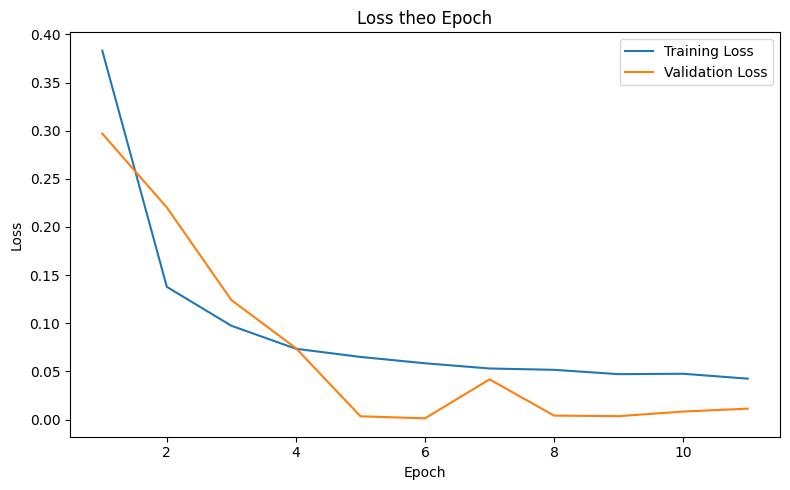

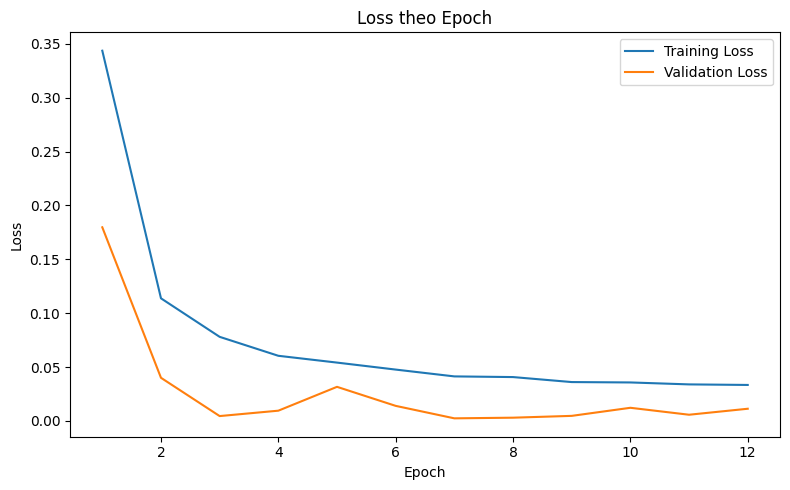

In [27]:
for company, res in results_LSTM.items():
    history = res['History']
    train_loss = history.history['loss']
    val_loss   = history.history.get('val_loss') 

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss,    label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss,  label='Validation Loss')

    plt.title('Loss theo Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluate Model

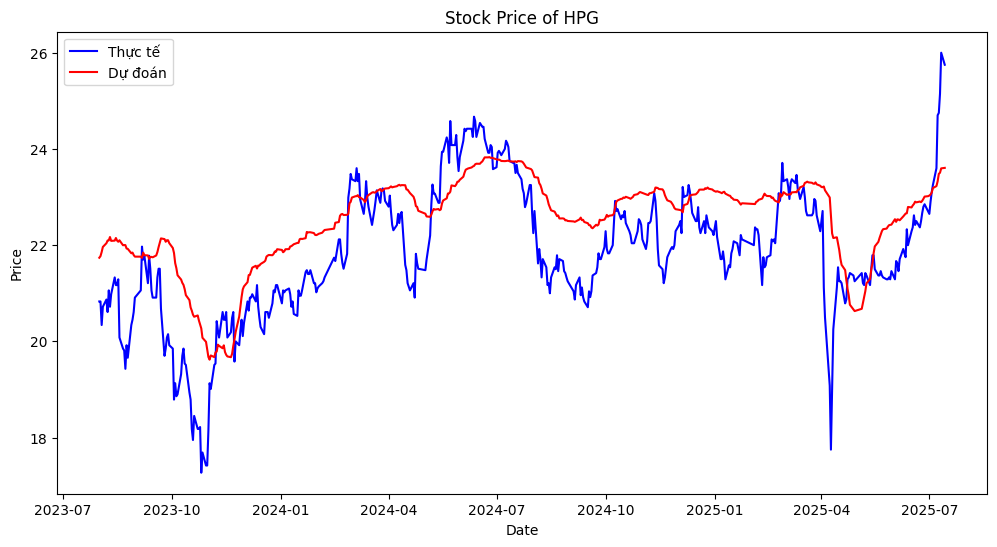

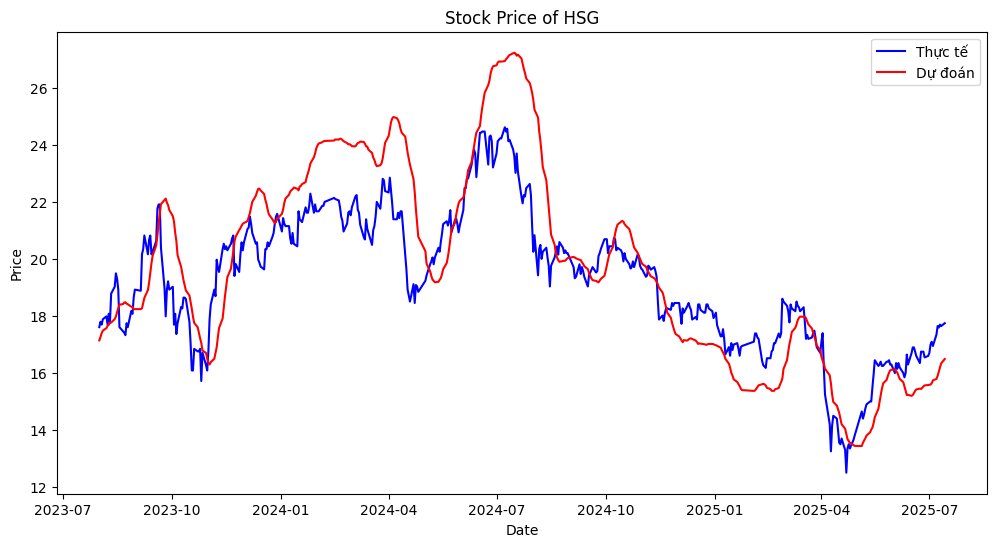

In [28]:
for company, data in results_LSTM.items():
    # size = int(0.8 * len(stocks[company]))
    # dates = stocks[company].iloc[size:].index
    plt.figure(figsize=(12, 6))
    plt.plot(data['Test dates'], data["Actual"], label="Thực tế", color="blue")
    plt.plot(data['Test dates'], data["Predict"], label="Dự đoán", color="red")
    plt.legend()
    plt.title(f"Stock Price of {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()  

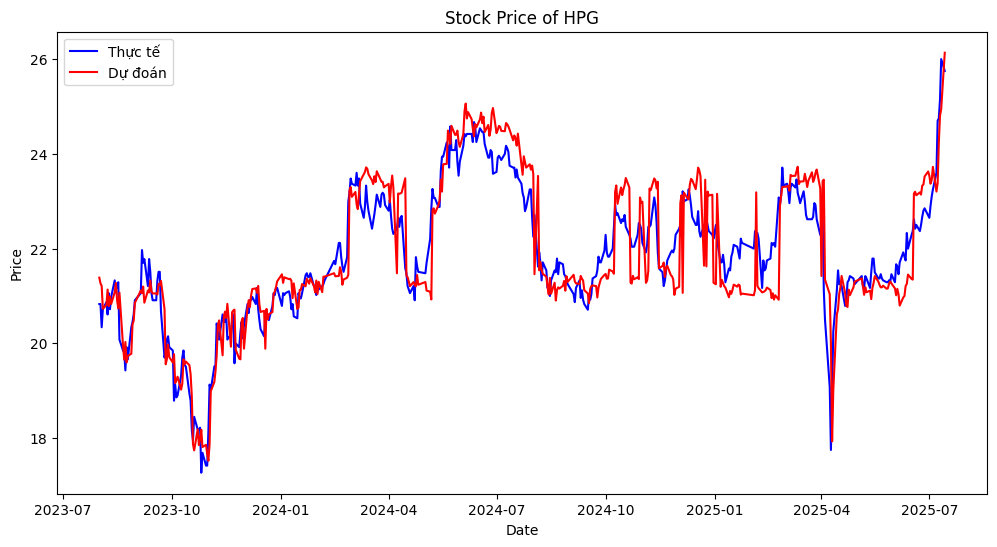

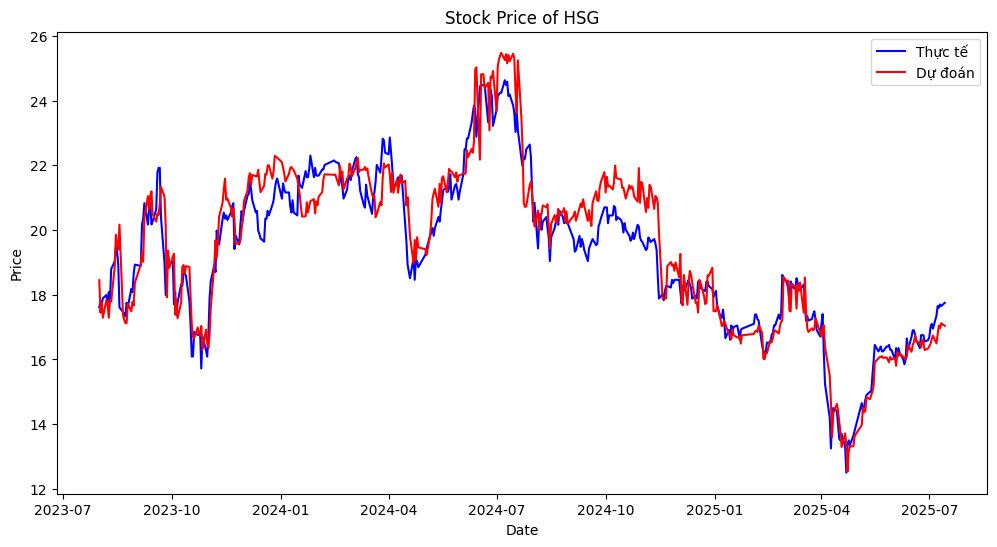

In [29]:
for company, data in results_xgb.items():
    # size = int(0.8 * len(stocks[company]))
    # dates = stocks[company].iloc[size:].index
    plt.figure(figsize=(12, 6))
    plt.plot(data['Test dates'], data["Actual"], label="Thực tế", color="blue")
    plt.plot(data['Test dates'], data["Predict"], label="Dự đoán", color="red")
    plt.legend()
    plt.title(f"Stock Price of {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()  

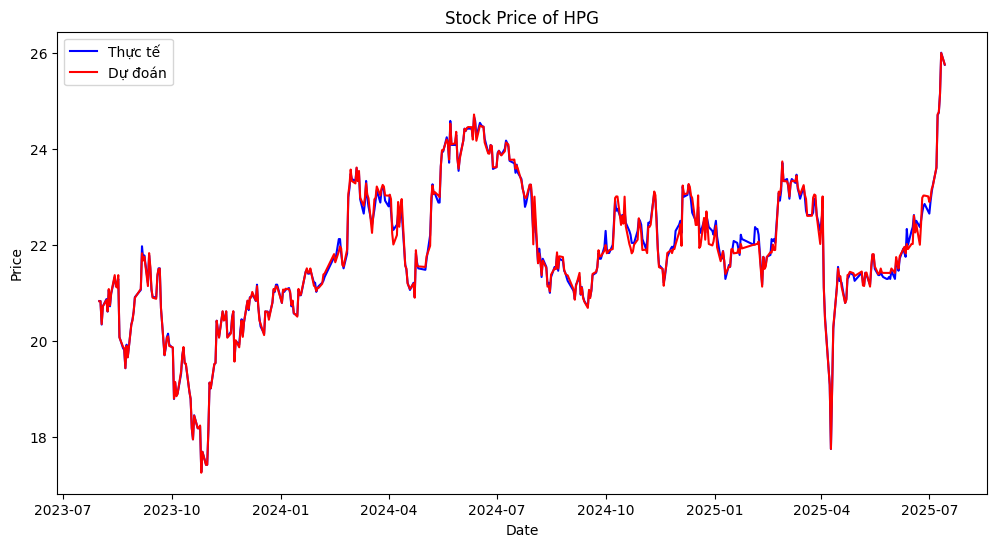

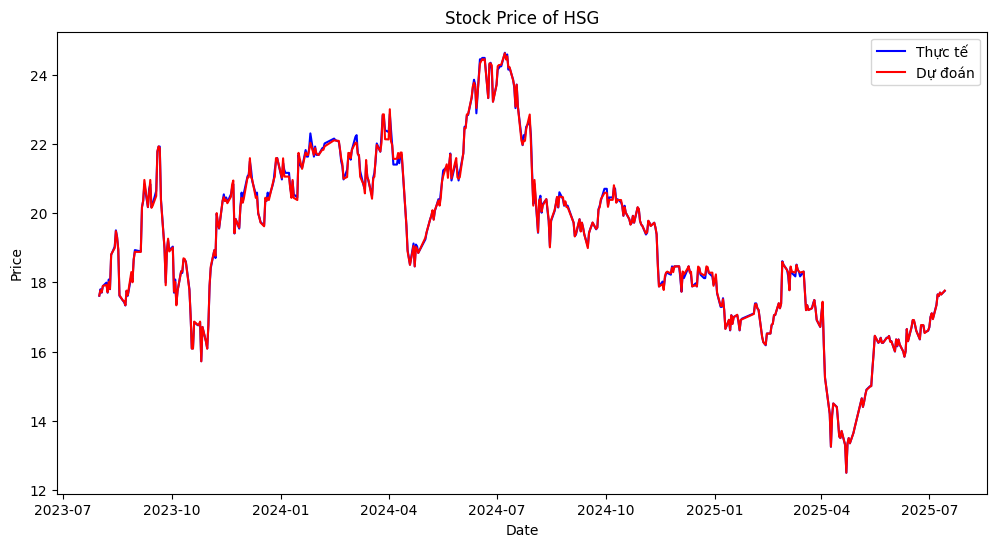

In [30]:
for company, data in results_meta_model.items():
    # size = int(0.8 * len(stocks[company]))
    # dates = stocks[company].iloc[size:].index
    plt.figure(figsize=(12, 6))
    plt.plot(data['Test dates'], data["Actual"], label="Thực tế", color="blue")
    plt.plot(data['Test dates'], data["Predict"], label="Dự đoán", color="red")
    plt.legend()
    plt.title(f"Stock Price of {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()  

In [108]:
# SHAP Explainability for XGBoost
def explain_model(model, X, feature_names):
    """
    Explain model predictions using SHAP values
    """
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar")
    plt.title('Feature Importance (SHAP Values)')
    plt.show()
    


Explaining XGBoost model for HPG


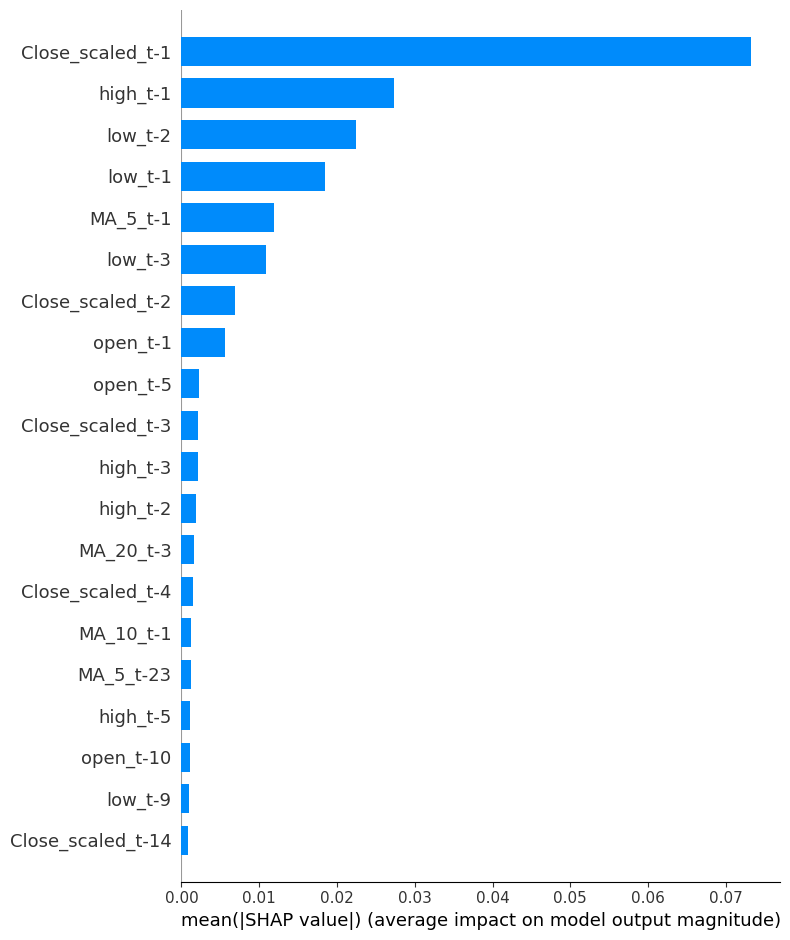

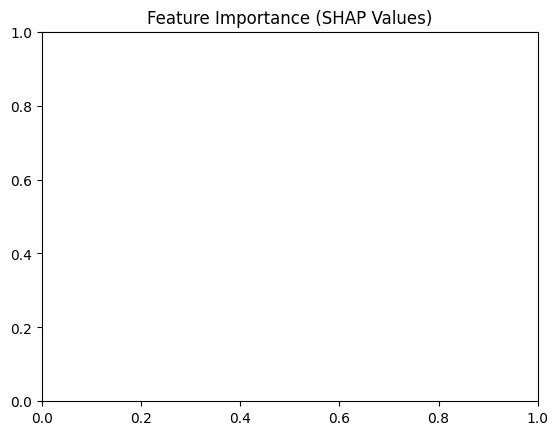

Explaining XGBoost model for HSG


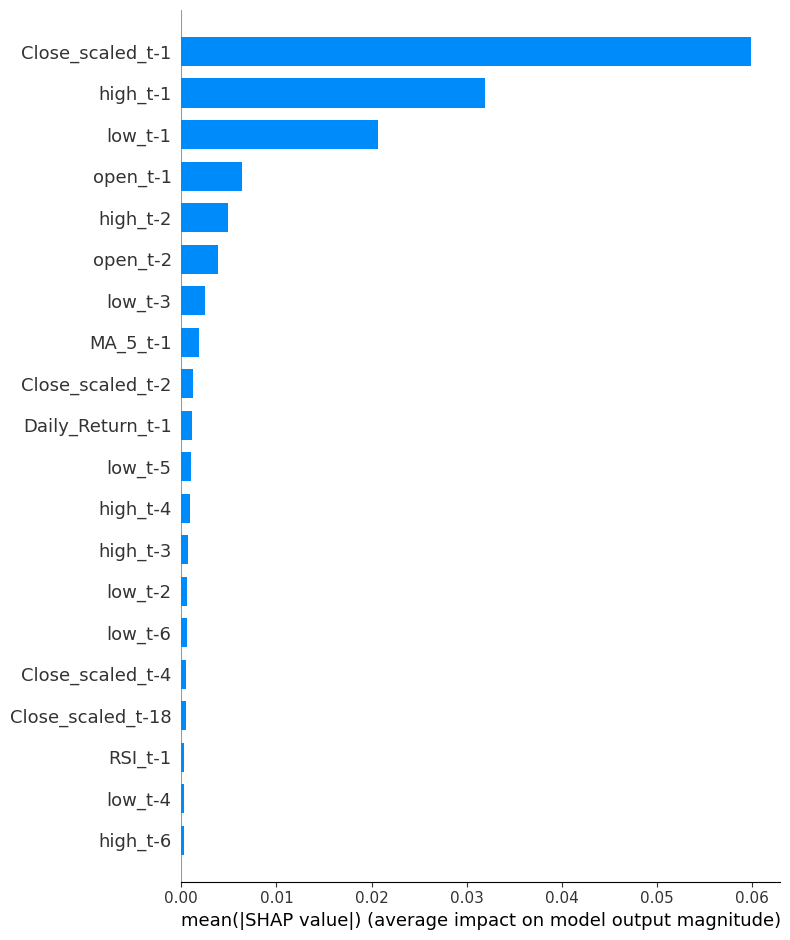

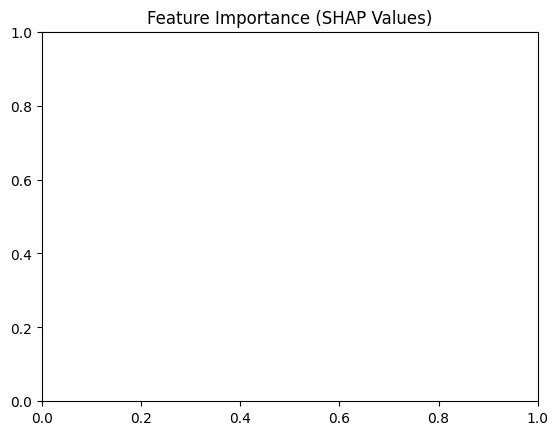

In [ ]:
for company, res in results_xgb.items():
    print(f"Explaining XGBoost model for {company}")
    
    # 1) Result of XGB
    xgb_res = res['model']
    
    # 2) Create features and normalize
    data = create_features(stocks[company])
    data, scaler_target, scaler_features = normalize_data(data)
    X_seq, y = create_sequences(data, time_steps=180)
    
    #    - Flatten window into vector
    N, ts, n_feat = X_seq.shape
    X_flat = X_seq.reshape(N, ts * n_feat)
    
    # 3) Split train/test
    split_at = int((1 - 0.2) * N)
    X_train_flat = X_flat[:split_at]
    
    # 4)  explain_model with 1000 first sample of train dataset
    feature_names = [
        f"{f}_t-{i}"
        for i in range(180, 0, -1)
        for f in ['open', 'high', 'low', 'Close_scaled', 'volume', 
                  'Price_Range', 'Daily_Return', 'MA_5', 'MA_10', 
                  'MA_20', 'Momentum_5', 'Momentum_10', 
                  'Volatility_5', 'Volatility_10', 'RSI']
    ]
    
    explain_model(
        xgb_res,
        X_train_flat[:1000], 
        feature_names
    )



Plotting predictions for HPG


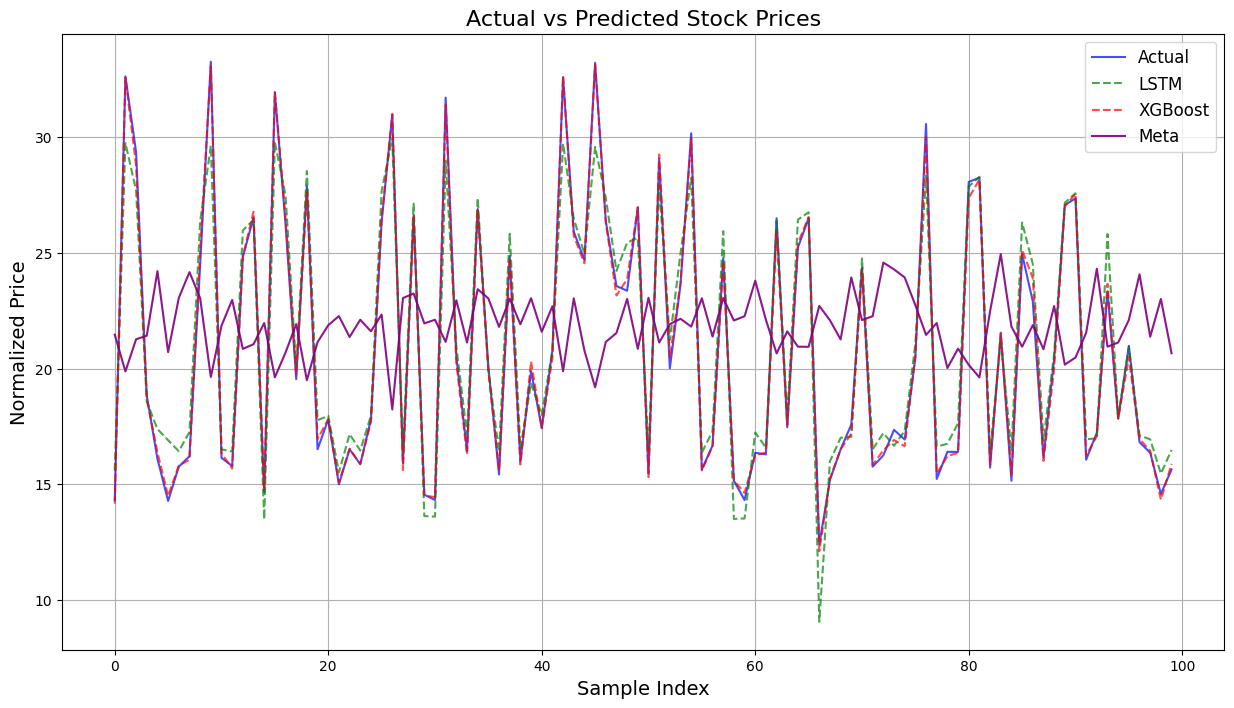

Plotting predictions for HSG


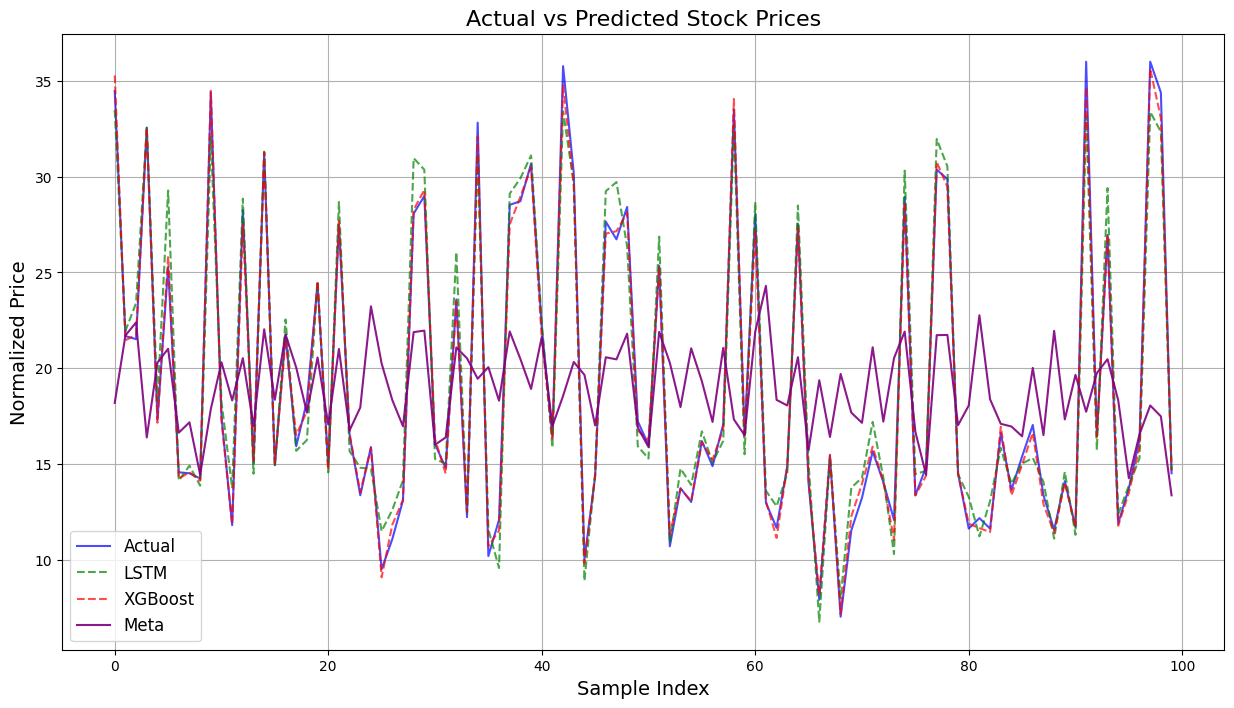

In [111]:
# def plot_predictions(y_true, lstm_pred, xgb_pred, meta_pred, n_samples=100):
#     """
#     Plot actual vs predicted values
#     """
#     plt.figure(figsize=(15, 8))
    
#     # Tìm độ dài nhỏ nhất trong bốn mảng
#     min_len = min(len(y_true), len(lstm_pred), len(xgb_pred), len(meta_pred))
    
#     # Chọn mẫu từ 0..min_len-1
#     idx = np.random.choice(min_len, size=min(n_samples, min_len), replace=False)
    
#     plt.plot(y_true[idx], label='Actual', color='blue', alpha=0.7)
#     plt.plot(lstm_pred[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
#     plt.plot(xgb_pred[idx], label='XGBoost', color='red', linestyle='--', alpha=0.7)
#     plt.plot(meta_pred[idx], label='Meta', color='purple', linestyle='-', alpha=0.9)
    
#     plt.title('Actual vs Predicted Stock Prices', fontsize=16)
#     plt.xlabel('Sample Index', fontsize=14)
#     plt.ylabel('Normalized Price', fontsize=14)
#     plt.legend(fontsize=12)
#     plt.grid(True)
#     plt.show()
    
# for company in stocks.keys():
#     print(f"Plotting predictions for {company}")
#     plot_predictions(
#         results_LSTM[company]['Actual'],
#         results_LSTM[company]['Predict'],
#         results_xgb[company]['Predict'],
#         results_meta_model[company]['Predict'],
#         n_samples=100
#     )

In [ ]:
def forecast_next_days(model, df, time_steps, n_days):
    """
    model     : LSTM đã train trên create_features(data)
    df        : DataFrame gốc chứa cột 'close', 'volume', …
    time_steps: window size (ví dụ 180)
    n_days    : số ngày muốn dự đoán
    """
    # 1) create features và scale
    data_feat = create_features(df)
    scaled_data, scaler_target, scaler_feat = normalize_data(data_feat)
    arr = scaled_data.values  # shape (n_samples, n_cols)

    # 2) Number of features input of model
    n_feat = model.input_shape[2] 

    # 3) Create initial window
    window = arr[-time_steps:, :n_feat]        # (time_steps, n_feat)
    window = window.reshape(1, time_steps, n_feat)

    preds_scaled = []
    for _ in range(n_days):
        # 4) Predict next value
        next_scaled = model.predict(window)[0, 0]
        preds_scaled.append(next_scaled)

        # 5) Update window
        # Add price predict to last window
        window = np.roll(window, -1, axis=1)  
        # Replace last feature with next_scaled
        if n_feat > 1:
            window[0, -1, 1:n_feat] = window[0, -2, 1:n_feat]
        # sign feature target
        window[0, -1, 0] = next_scaled

    # 6) Un‑scale target
    preds = scaler_target.inverse_transform(
        np.array(preds_scaled).reshape(-1, 1)
    ).ravel()
    return preds


In [ ]:

def print_forecasts_with_real_dates_LSTM(results_LSTM, stocks, forecast_func, time_steps, n_days):
    for company, results in results_LSTM.items():
        print(f"\nDự đoán {n_days} ngày tiếp theo cho công ty {company}:")
        
        # 1) Initial DataFrame 
        df = stocks[company]
        idx = df.index
        
        # 2) Determine freq of index ('B'  là business day, 'D' la daily)
        #    Nếu infer_freq trả về None, fallback về 'B'
        freq = pd.infer_freq(idx)
        if freq is None:
            freq = 'B'
        
        # 3) Take last date from index
        last_date = idx[-1]
        
        # 4) Create n_days next days with freq
        #    create date_range 1 steps longer, then remove first element
        all_dates = pd.date_range(start=last_date, periods=n_days + 1, freq=freq)
        next_dates = all_dates[1:]
        
        # 5) Take array scaled_close used in training process
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_close = scaler.fit_transform(df[['close']].values).ravel()
        
        # 6) Predict next n_days
        preds = forecast_func(
            model      = results['model'],
            df         = df,
            time_steps = time_steps,
            n_days     = n_days
        )

        
        # 7) Print results
        for date, price in zip(next_dates, preds):
            print(f"{date.day:02d}/{date.month:02d}/{date.year} → {price:.2f}")


In [ ]:
print_forecasts_with_real_dates_LSTM(results_LSTM, stocks, forecast_next_days, time_steps=180, n_days=5)


Dự đoán 5 ngày tiếp theo cho công ty HPG:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
15/07/2025 → 23.78
16/07/2025 → 24.14
17/07/2025 → 24.43
18/07/2025 → 24.68
21/07/2025 → 24.87

Dự đoán 5 ngày tiếp theo cho công ty HSG:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
15/07/2025 → 16.94
16/07/2025 → 16.91
17/07/2025 → 16.86
18/07/2025 → 16.80
21/07/2025 → 16.75


In [10]:
def forecast_next_days_meta(meta_model, lstm_model, xgb_model, df, time_steps, n_days):
    # 1) Scale & features
    data_feat = create_features(df)
    scaled_data, scaler_target, scaler_feat = normalize_data(data_feat)
    arr = scaled_data.values
    N, total_feat = arr.shape

    # 2) Window for LSTM
    n_feat_lstm = lstm_model.input_shape[2]
    window = arr[-time_steps:, :n_feat_lstm].reshape(1, time_steps, n_feat_lstm)

    preds_meta_scaled = []
    for _ in range(n_days):
        # Base predictions (scaled)
        p_lstm = lstm_model.predict(window)[0,0]
        flat   = window.reshape(1, time_steps * n_feat_lstm)
        p_xgb  = xgb_model.predict(flat)[0]

        # residual và diff 
        last_scaled = window[0, -1, 0]
        res_lstm = last_scaled - p_lstm
        res_xgb  = last_scaled - p_xgb
        diff     = p_lstm - p_xgb
        abs_diff = abs(diff)

        # create 6 feature
        X_meta = np.array([[p_lstm, p_xgb, res_lstm, res_xgb, diff, abs_diff]])

        # Meta prediction (scaled)
        p_meta = meta_model.predict(X_meta)[0]
        preds_meta_scaled.append(p_meta)

        # Shift window and update
        window = np.roll(window, -1, axis=1)
        if n_feat_lstm > 1:
            window[0, -1, 1:] = window[0, -2, 1:]
        window[0, -1, 0] = p_meta

    # Un‑scale
    return scaler_target.inverse_transform(
        np.array(preds_meta_scaled).reshape(-1,1)
    ).ravel()


In [11]:

def print_forecasts_with_real_dates_meta(company, results_meta_model, stocks, forecast_func, time_steps, n_days):
    records = []
    # for company, results in results_meta_model.items():
    print(f"\nDự đoán {n_days} ngày tiếp theo cho công ty {company}:")
    
    # 1) Initial DataFrame and index
    df = stocks[company]
    idx = df.index
    
    # 2) Determine freq of index ('B'  là business day, 'D' la daily)
    #    Nếu infer_freq trả về None, fallback về 'B'
    freq = pd.infer_freq(idx)
    if freq is None:
        freq = 'B'
    
    # 3) Take last date from index
    last_date = idx[-1]
    
    # 4) Create n_days next days with freq
    #    create date_range 1 steps longer, then remove first element
    all_dates = pd.date_range(start=last_date, periods=n_days + 1, freq=freq)
    next_dates = all_dates[1:]
    
    # 5) Take array scaled_close used in training process
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(df[['close']].values).ravel()
    
    # 6) Predict next n_days
    preds_meta = forecast_next_days_meta(
        meta_model = results_meta_model[company]['meta_model'],
        lstm_model  = results_LSTM[company]['model'],
        xgb_model   = results_xgb[company]['model'],
        df          = df,
        time_steps = 180,
        n_days     = 5
    )
    # Get history price to find min/max 30 nearest days
    history_prices = df['close'].values[-30:]
    signals = []
    for i, p in enumerate(preds_meta):
        window = list(history_prices) + list(preds_meta[:i+1])
        if len(window) > 30:
            window = window[-30:]
        if p <= min(window):
            sig = 'BUY'
        elif p >= max(window):
            sig = 'SELL'
        else:
            sig = 'HOLD'
        signals.append(sig)

    
    for date, price, sig in zip(next_dates, preds_meta, signals):
        records.append({
            'company': company,
            'date': date,
            'predicted_close': price,
            'signal': sig
        })

    return pd.DataFrame(records)



In [12]:
print_forecasts_with_real_dates_meta('HPG', results_meta_model, stocks, forecast_next_days_meta, time_steps=180, n_days=5)


Dự đoán 5 ngày tiếp theo cho công ty HPG:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


,company,date,predicted_close,signal
0,HPG,2025-07-15,25.9087,HOLD
1,HPG,2025-07-16,25.9618,HOLD
2,HPG,2025-07-17,25.9594,HOLD
3,HPG,2025-07-18,25.8603,HOLD
4,HPG,2025-07-21,25.9603,HOLD


In [27]:
print_forecasts_with_real_dates_meta('HSG', results_meta_model, stocks, forecast_next_days_meta, time_steps=180, n_days=5)


Dự đoán 5 ngày tiếp theo cho công ty HSG:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


,company,date,predicted_close,signal
0,HSG,2025-07-15,17.6716,HOLD
1,HSG,2025-07-16,17.6376,HOLD
2,HSG,2025-07-17,17.6526,HOLD
3,HSG,2025-07-18,17.6017,HOLD
4,HSG,2025-07-21,17.6038,HOLD


In [ ]:
#save model
jb.dump(results_LSTM, r"C:\Users\user\Documents\python\Samsung\results_LSTM_full.pkl")
jb.dump(results_xgb, r"C:\Users\user\Documents\python\Samsung\results_xgb_full.pkl")
jb.dump(results_meta_model, r"C:\Users\user\Documents\python\Samsung\results_meta_model_full.pkl")

## Key Findings & Conclusion

## Kết luận

Tôi đã xây dựng và đánh giá một mô hình lai kết hợp giữa **LSTM** và **XGBoost** nhằm dự báo giá cổ phiếu trong tương lai. Kết quả thực nghiệm cho thấy:

- Mô hình kết hợp đạt hiệu suất cao với hệ số R² lên đến **0.99**, cho thấy khả năng giải thích biến động giá khá tốt.
- LSTM khai thác hiệu quả chuỗi thời gian, trong khi XGBoost tối ưu hóa lựa chọn đặc trưng, giúp cải thiện chất lượng đầu vào cho mô hình tổng hợp.
- Các chỉ báo kỹ thuật như **moving average, RSI** và **giá đóng cửa quá khứ** là những yếu tố có ảnh hưởng rõ rệt đến khả năng dự báo.

### Gợi ý ứng dụng thực tiễn

- Do tính chất biến động của thị trường, nên triển khai mô hình theo hướng:
  - Huấn luyện lại định kỳ
  - Tích hợp phân tích tin tức và cảm xúc thị trường
  - Áp dụng học trực tuyến (online learning) để thích ứng nhanh với thay đổi

### Hạn chế

- Mô hình không thể phản ánh hết các yếu tố phi kỹ thuật như tâm lý thị trường, chính sách vĩ mô hoặc sự kiện bất ngờ.
- Dữ liệu lịch sử không đảm bảo hiệu quả tuyệt đối trong việc dự đoán tương lai.
- Không nên sử dụng mô hình như một công cụ ra quyết định duy nhất, mà nên kết hợp với phân tích cơ bản và phân tích kỹ thuật truyền thống.

---

Tóm lại, việc kết hợp XGBoost và LSTM trong dự báo tài chính cho thấy tiềm năng lớn, nhưng cần triển khai cẩn trọng, cập nhật thường xuyên và gắn liền với bối cảnh thị trường thực tế để đạt hiệu quả tối ưu.
